In [3]:
import pandas as pd

In [4]:
matches=pd.read_csv("pl_matches.csv",index_col=0)

In [5]:
matches.shape

(2280, 27)

In [6]:
matches["team"].value_counts()

Manchester City             114
West Ham United             114
Brentford                   114
Everton                     114
Wolverhampton Wanderers     114
Arsenal                     114
Brighton and Hove Albion    114
Crystal Palace              114
Manchester United           114
Newcastle United            114
Chelsea                     114
Tottenham Hotspur           114
Aston Villa                 114
Liverpool                   114
Burnley                      76
Southampton                  76
Leeds United                 76
Leicester City               76
Fulham                       76
Nottingham Forest            76
Bournemouth                  76
Sheffield United             38
Luton Town                   38
Watford                      38
Norwich City                 38
Name: team, dtype: int64

In [7]:
matches["comp"].value_counts()

Premier League    2280
Name: comp, dtype: int64

In [8]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [9]:
matches["season"].value_counts()

2023    760
2022    760
2021    760
Name: season, dtype: int64

In [10]:
matches["round"].value_counts()

Matchweek 1     60
Matchweek 30    60
Matchweek 23    60
Matchweek 24    60
Matchweek 25    60
Matchweek 18    60
Matchweek 26    60
Matchweek 27    60
Matchweek 28    60
Matchweek 31    60
Matchweek 2     60
Matchweek 32    60
Matchweek 33    60
Matchweek 29    60
Matchweek 35    60
Matchweek 36    60
Matchweek 37    60
Matchweek 34    60
Matchweek 22    60
Matchweek 21    60
Matchweek 20    60
Matchweek 19    60
Matchweek 3     60
Matchweek 4     60
Matchweek 5     60
Matchweek 6     60
Matchweek 7     60
Matchweek 8     60
Matchweek 9     60
Matchweek 10    60
Matchweek 11    60
Matchweek 12    60
Matchweek 13    60
Matchweek 14    60
Matchweek 15    60
Matchweek 16    60
Matchweek 17    60
Matchweek 38    60
Name: round, dtype: int64

In [11]:
matches.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf                int64
ga                int64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk                int64
pkatt             int64
season            int64
team             object
dtype: object

In [12]:
del matches["comp"]
del matches["notes"]

In [13]:
matches["match report"].head(10)

1     Match Report
3     Match Report
4     Match Report
5     Match Report
6     Match Report
8     Match Report
10    Match Report
12    Match Report
13    Match Report
15    Match Report
Name: match report, dtype: object

In [14]:
matches["date"]=pd.to_datetime(matches["date"])

In [15]:
matches["target"] = (matches["result"] == "W").astype("int")
# True (Win) =1
# False (Draw, Loss) =0

In [16]:
matches["target"].value_counts()

0    1397
1     883
Name: target, dtype: int64

In [17]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek

In [18]:
matches.dtypes

date            datetime64[ns]
time                    object
round                   object
day                     object
venue                   object
result                  object
gf                       int64
ga                       int64
opponent                object
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                 object
formation               object
referee                 object
match report            object
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                       int64
pkatt                    int64
season                   int64
team                    object
target                   int64
venue_code                int8
opp_code                  int8
hour                     int64
day_code                 int64
dtype: object

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rf=RandomForestClassifier(n_estimators=50,min_samples_split=10,random_state=1)

In [21]:
train = matches[matches["date"] < '2023-01-01']
test = matches[matches["date"] > '2023-01-01']

In [22]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]

In [23]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [24]:
preds = rf.predict(test[predictors])

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
error = accuracy_score(test["target"], preds)
error

0.6077441077441077

In [27]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,572,153
1,313,150


In [28]:
from sklearn.metrics import precision_score

In [29]:
precision_score(test["target"], preds)

0.49504950495049505

In [30]:
grouped_matches = matches.groupby("team")

In [31]:
group = grouped_matches.get_group("Manchester City").sort_values("date")

In [32]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [33]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

rolling_averages(group, cols, new_cols)

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,...,15,5,3.333333,0.333333,19.666667,6.000000,16.866667,0.666667,0.000000,0.000000
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0,0,Southampton,1.0,...,15,5,3.666667,0.000000,22.000000,7.333333,15.866667,0.333333,0.000000,0.000000
8,2021-09-25,12:30,Matchweek 6,Sat,Away,W,1,0,Chelsea,1.7,...,12,5,2.000000,0.000000,22.000000,6.333333,15.166667,0.333333,0.000000,0.000000
10,2021-10-03,16:30,Matchweek 7,Sun,Away,D,2,2,Liverpool,1.2,...,16,6,0.666667,0.000000,18.666667,4.000000,15.933333,0.333333,0.000000,0.000000
11,2021-10-16,15:00,Matchweek 8,Sat,Home,W,2,0,Burnley,2.1,...,15,5,1.000000,0.666667,14.333333,2.333333,16.833333,0.666667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2024-04-28,16:30,Matchweek 35,Sun,Away,W,2,0,Nott'ham Forest,0.9,...,16,6,4.333333,1.000000,22.666667,8.666667,16.666667,0.333333,0.333333,0.333333
52,2024-05-04,17:30,Matchweek 36,Sat,Home,W,5,1,Wolves,3.7,...,17,5,3.666667,0.333333,20.333333,7.666667,17.533333,0.666667,0.333333,0.333333
53,2024-05-11,12:30,Matchweek 37,Sat,Away,W,4,0,Fulham,3.2,...,12,5,3.666667,0.333333,14.333333,7.000000,17.000000,0.666667,0.666667,0.666667
54,2024-05-14,20:00,Matchweek 34,Tue,Away,W,2,0,Tottenham,2.4,...,20,1,3.666667,0.333333,14.666667,7.666667,17.200000,0.333333,1.000000,1.000000


In [34]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))

In [35]:
matches_rolling

date   time         round  day venue result  \
team                                                                           
Arsenal                 4  2021-09-11  15:00   Matchweek 4  Sat  Home      W   
                        5  2021-09-18  15:00   Matchweek 5  Sat  Away      W   
                        7  2021-09-26  16:30   Matchweek 6  Sun  Home      W   
                        8  2021-10-02  17:30   Matchweek 7  Sat  Away      D   
                        9  2021-10-18  20:00   Matchweek 8  Mon  Home      D   
...                               ...    ...           ...  ...   ...    ...   
Wolverhampton Wanderers 40 2024-04-24  19:45  Matchweek 29  Wed  Home      L   
                        41 2024-04-27  15:00  Matchweek 35  Sat  Home      W   
                        42 2024-05-04  17:30  Matchweek 36  Sat  Away      L   
                        43 2024-05-11  15:00  Matchweek 37  Sat  Home      L   
                        44 2024-05-19  16:00  Matchweek 38  Sun  Away      L   

                            gf  ga         opponent   xg  ...  hour  day_code  \
team                                                      ...                   
Arsenal                 4    1   0     Norwich City  2.7  ...    15         5   
                        5    1   0          Burnley  1.1  ...    15         5   
                        7    3   1        Tottenham  1.1  ...    16         6   
                        8    0   0         Brighton  0.4  ...    17         5   
                        9    2   2   Crystal Palace  1.7  ...    20         0   
...                         ..  ..              ...  ...  ...   ...       ...   
Wolverhampton Wanderers 40   0   1      Bournemouth  0.5  ...    19         2   
                        41   2   1       Luton Town  1.2  ...    15         5   
                        42   1   5  Manchester City  0.3  ...    17         5   
                        43   1   3   Crystal Palace  1.6  ...    15         5   
                        44   0   2        Liverpool  0.5  ...    16         6   

                            gf_rolling ga_rolling sh_rolling sot_rolling  \
team                                                                       
Arsenal                 4     0.000000   3.000000   9.666667    2.333333   
                        5     0.333333   2.333333  12.333333    3.000000   
                        7     0.666667   1.666667  14.666667    3.000000   
                        8     1.666667   0.333333  18.333333    5.333333   
                        9     1.333333   0.333333  11.000000    4.000000   
...                                ...        ...        ...         ...   
Wolverhampton Wanderers 40    1.000000   2.000000   9.666667    4.000000   
                        41    0.666667   1.666667  10.333333    3.333333   
                        42    0.666667   1.333333  11.000000    4.000000   
                        43    1.000000   2.333333  10.000000    3.333333   
                        44    1.333333   3.000000   9.666667    4.666667   

                           dist_rolling  fk_rolling  pk_rolling  pkatt_rolling  
team                                                                            
Arsenal                 4     14.833333    0.333333    0.000000       0.000000  
                        5     14.133333    0.333333    0.000000       0.000000  
                        7     14.800000    0.666667    0.000000       0.000000  
                        8     18.433333    0.666667    0.000000       0.000000  
                        9     19.833333    0.666667    0.000000       0.000000  
...                                 ...         ...         ...            ...  
Wolverhampton Wanderers 40    20.533333    0.333333    0.333333       0.333333  
                        41    18.766667    0.000000    0.000000       0.000000  
                        42    19.666667    0.000000    0.000000       0.000000  
                        43    15.966667    0.000000    0.0

In [36]:
matches_rolling = matches_rolling.droplevel('team')
matches_rolling

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
4,2021-09-11,15:00,Matchweek 4,Sat,Home,W,1,0,Norwich City,2.7,...,15,5,0.000000,3.000000,9.666667,2.333333,14.833333,0.333333,0.000000,0.000000
5,2021-09-18,15:00,Matchweek 5,Sat,Away,W,1,0,Burnley,1.1,...,15,5,0.333333,2.333333,12.333333,3.000000,14.133333,0.333333,0.000000,0.000000
7,2021-09-26,16:30,Matchweek 6,Sun,Home,W,3,1,Tottenham,1.1,...,16,6,0.666667,1.666667,14.666667,3.000000,14.800000,0.666667,0.000000,0.000000
8,2021-10-02,17:30,Matchweek 7,Sat,Away,D,0,0,Brighton,0.4,...,17,5,1.666667,0.333333,18.333333,5.333333,18.433333,0.666667,0.000000,0.000000
9,2021-10-18,20:00,Matchweek 8,Mon,Home,D,2,2,Crystal Palace,1.7,...,20,0,1.333333,0.333333,11.000000,4.000000,19.833333,0.666667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,2024-04-24,19:45,Matchweek 29,Wed,Home,L,0,1,Bournemouth,0.5,...,19,2,1.000000,2.000000,9.666667,4.000000,20.533333,0.333333,0.333333,0.333333
41,2024-04-27,15:00,Matchweek 35,Sat,Home,W,2,1,Luton Town,1.2,...,15,5,0.666667,1.666667,10.333333,3.333333,18.766667,0.000000,0.000000,0.000000
42,2024-05-04,17:30,Matchweek 36,Sat,Away,L,1,5,Manchester City,0.3,...,17,5,0.666667,1.333333,11.000000,4.000000,19.666667,0.000000,0.000000,0.000000
43,2024-05-11,15:00,Matchweek 37,Sat,Home,L,1,3,Crystal Palace,1.6,...,15,5,1.000000,2.333333,10.000000,3.333333,15.966667,0.000000,0.000000,0.000000


In [37]:
matches_rolling.index = range(matches_rolling.shape[0])

In [38]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    error = precision_score(test["target"], preds)
    return combined, error

In [39]:
combined, error = make_predictions(matches_rolling, predictors + new_cols)
error

0.539906103286385

In [40]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)
combined.head(10)

,actual,predicted,date,team,opponent,result
17,0,0,2022-01-23,Arsenal,Burnley,D
18,1,0,2022-02-10,Arsenal,Wolves,W
19,1,0,2022-02-19,Arsenal,Brentford,W
20,1,1,2022-02-24,Arsenal,Wolves,W
21,1,1,2022-03-06,Arsenal,Watford,W
22,1,1,2022-03-13,Arsenal,Leicester City,W
23,0,1,2022-03-16,Arsenal,Liverpool,L
24,1,0,2022-03-19,Arsenal,Aston Villa,W
25,0,0,2022-04-04,Arsenal,Crystal Palace,L
26,0,0,2022-04-09,Arsenal,Brighton,L


In [41]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd", "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)

In [42]:
combined["new_team"] = combined["team"].map(mapping)

In [43]:
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])
merged

,actual_x,predicted_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,opponent_y,result_y,new_team_y
0,0,0,2022-01-23,Arsenal,Burnley,D,Arsenal,0,0,Burnley,Arsenal,D,Burnley
1,1,0,2022-02-10,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
2,1,0,2022-02-19,Arsenal,Brentford,W,Arsenal,0,0,Brentford,Arsenal,L,Brentford
3,1,1,2022-02-24,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
4,1,1,2022-03-06,Arsenal,Watford,W,Arsenal,0,0,Watford,Arsenal,L,Watford
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,0,0,2024-04-24,Wolverhampton Wanderers,Bournemouth,L,Wolves,1,0,Bournemouth,Wolves,W,Bournemouth
1767,1,0,2024-04-27,Wolverhampton Wanderers,Luton Town,W,Wolves,0,0,Luton Town,Wolves,L,Luton Town
1768,0,0,2024-05-04,Wolverhampton Wanderers,Manchester City,L,Wolves,1,1,Manchester City,Wolves,W,Manchester City
1769,0,0,2024-05-11,Wolverhampton Wanderers,Crystal Palace,L,Wolves,1,1,Crystal Palace,Wolves,W,Crystal Palace


In [44]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==0)]["actual_x"].value_counts()

1    195
0    142
Name: actual_x, dtype: int64

In [45]:
### END OF ORIGINAL NOTEBOOK

In [46]:
matches["formation"].value_counts()

4-2-3-1       720
4-3-3         579
3-4-3         269
4-4-2         206
3-5-2         121
4-1-4-1        82
4-4-1-1        71
5-3-2          45
5-4-1          33
3-4-1-2        26
3-2-4-1        21
4-3-1-2        20
4-5-1          17
4-3-2-1        16
4-1-2-1-2◆     16
4-2-2-2        12
3-5-1-1         9
3-3-3-1         7
3-1-4-2         7
4-2-4-0         2
3-4-3◆          1
Name: formation, dtype: int64

In [47]:
matches["captain"].value_counts()

Lewis Dunk           98
Martin Ødegaard      79
James Ward-Prowse    75
Bruno Fernandes      73
Declan Rice          70
                     ..
José Sá               1
Casemiro              1
Marcos Alonso         1
Marc Albrighton       1
Ashley Young          1
Name: captain, Length: 135, dtype: int64

In [48]:
matches["referee"].value_counts()

Anthony Taylor       170
Paul Tierney         164
Michael Oliver       160
Simon Hooper         138
Craig Pawson         132
Andy Madley          126
Stuart Attwell       124
Robert Jones         120
David Coote          114
Chris Kavanagh       102
Jarred Gillett        94
Darren England        90
John Brooks           90
Peter Bankes          86
Michael Salisbury     64
Andre Marriner        64
Martin Atkinson       52
Mike Dean             52
Jonathan Moss         50
Graham Scott          48
Tim Robinson          46
Thomas Bramall        38
Tony Harrington       38
Kevin Friend          36
Samuel Barrott        30
Darren Bond           18
Joshua Smith          10
Samuel Allison         6
Lewis Smith            4
Robert Madley          4
Rebecca Welch          4
Matt Donohue           4
Sunny Singh            2
Name: referee, dtype: int64

In [49]:
d_matches=matches.copy(deep=True)

In [50]:
d_matches.dtypes

date            datetime64[ns]
time                    object
round                   object
day                     object
venue                   object
result                  object
gf                       int64
ga                       int64
opponent                object
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                 object
formation               object
referee                 object
match report            object
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                       int64
pkatt                    int64
season                   int64
team                    object
target                   int64
venue_code                int8
opp_code                  int8
hour                     int64
day_code                 int64
dtype: object

In [51]:
del d_matches["day"]
del d_matches["captain"]
del d_matches["referee"]
del d_matches["match report"]

In [52]:
d_matches.dtypes

date          datetime64[ns]
time                  object
round                 object
venue                 object
result                object
gf                     int64
ga                     int64
opponent              object
xg                   float64
xga                  float64
poss                 float64
attendance           float64
formation             object
sh                   float64
sot                  float64
dist                 float64
fk                   float64
pk                     int64
pkatt                  int64
season                 int64
team                  object
target                 int64
venue_code              int8
opp_code                int8
hour                   int64
day_code               int64
dtype: object

In [53]:
d_matches["time"].head()

1    20:00
3    20:00
4    14:00
5    15:00
6    15:00
Name: time, dtype: object

In [54]:
d_matches["time"] = pd.to_timedelta(d_matches["time"]+ ":00")

In [55]:
d_matches["time"].head()

1   0 days 20:00:00
3   0 days 20:00:00
4   0 days 14:00:00
5   0 days 15:00:00
6   0 days 15:00:00
Name: time, dtype: timedelta64[ns]

In [56]:
d_matches["datetime"]=d_matches["date"]+d_matches["time"]

In [57]:
d_matches["datetime"].head()

1   2023-08-11 20:00:00
3   2023-08-19 20:00:00
4   2023-08-27 14:00:00
5   2023-09-02 15:00:00
6   2023-09-16 15:00:00
Name: datetime, dtype: datetime64[ns]

In [58]:
del d_matches["round"]

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

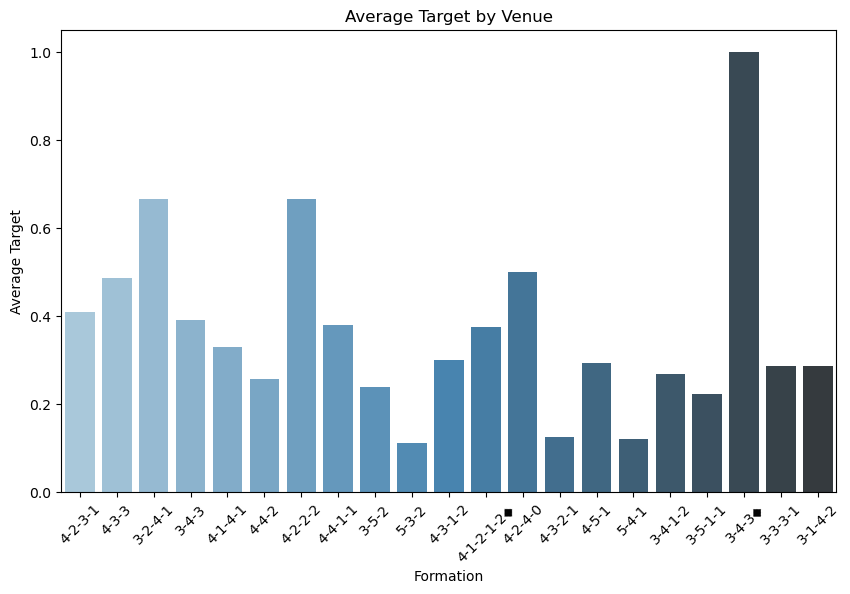

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(x="formation", y="target", data=d_matches, estimator=np.mean, ci=None, palette="Blues_d")
plt.xlabel("Formation")
plt.ylabel("Average Target")
plt.title("Average Target by Venue")
plt.xticks(rotation=45)  # Rotate venue names for better readability
plt.show()

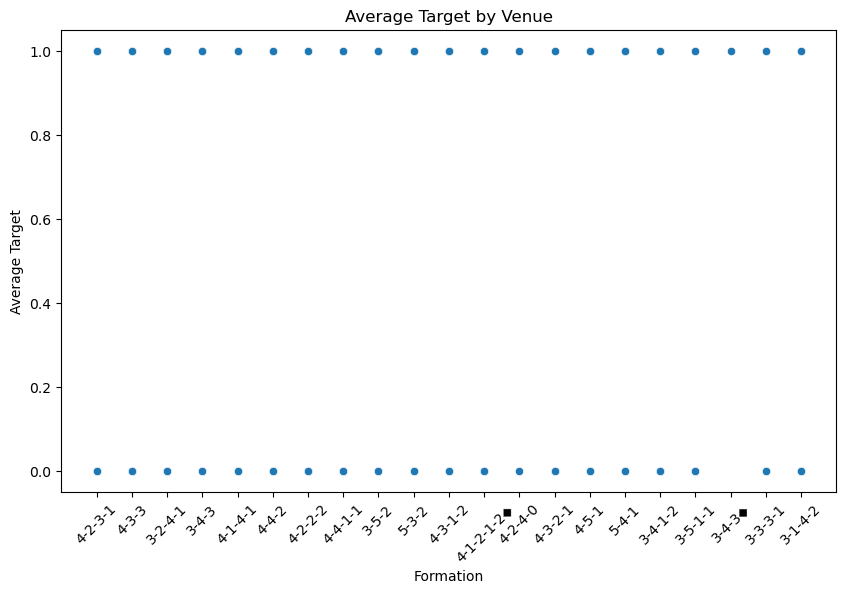

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="formation", y="target", data=d_matches, palette="Blues_d")
plt.xlabel("Formation")
plt.ylabel("Average Target")
plt.title("Average Target by Venue")
plt.xticks(rotation=45)  # Rotate venue names for better readability
plt.show()

In [62]:
del d_matches["formation"]

In [63]:
d_rf=RandomForestClassifier(n_estimators=100,min_samples_split=10,random_state=1)

In [64]:
d_train = d_matches[matches["date"] < '2024-01-01']
d_test = d_matches[matches["date"] > '2024-01-01']

In [65]:
d_train.shape

(1912, 25)

In [66]:
d_test.shape

(366, 25)

In [67]:
d_matches.dtypes

date           datetime64[ns]
time          timedelta64[ns]
venue                  object
result                 object
gf                      int64
ga                      int64
opponent               object
xg                    float64
xga                   float64
poss                  float64
attendance            float64
sh                    float64
sot                   float64
dist                  float64
fk                    float64
pk                      int64
pkatt                   int64
season                  int64
team                   object
target                  int64
venue_code               int8
opp_code                 int8
hour                    int64
day_code                int64
datetime       datetime64[ns]
dtype: object

In [68]:
predictors = ["venue_code", "opp_code", "hour", "day_code", "xg","xga","poss","sh","sot"]

In [69]:
d_rf.fit(d_train[predictors],d_train["target"])

RandomForestClassifier(min_samples_split=10, random_state=1)

In [70]:
d_preds = d_rf.predict(d_test[predictors])

In [71]:
precision_score(d_test["target"], d_preds)

0.6821705426356589

In [72]:
accuracy_score(d_test["target"], d_preds)

0.7540983606557377

In [73]:
from sklearn.metrics import f1_score

In [74]:
f1_score(d_test["target"], d_preds)

0.6616541353383458

In [75]:
def d_rolling_averages(d_group, d_cols, d_new_cols):
    d_group = d_group.sort_values("date")
    d_rolling_stats = d_group[d_cols].rolling(3, closed='left').mean()
    d_group[d_new_cols] = d_rolling_stats
    d_group = d_group.dropna(subset=d_new_cols)
    return d_group

In [77]:
d_grouped_matches = matches.groupby("team")

In [78]:
d_group=d_grouped_matches.get_group("Manchester City")

In [79]:
d_cols = ["gf", "ga", "sh","sot", "dist", "fk", "pk", "pkatt","xg","xga","poss"]
d_new_cols = [f"{c}_rolling" for c in d_cols]

In [80]:
len(d_new_cols)

11

In [81]:
d_rolling_averages(d_group,d_cols,d_new_cols)

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,xg_rolling,xga_rolling,poss_rolling
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.8,...,0.333333,19.666667,6.000000,16.866667,0.666667,0.000000,0.000000,2.933333,0.433333,70.666667
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0,0,Southampton,1.0,...,0.000000,22.000000,7.333333,15.866667,0.333333,0.000000,0.000000,3.266667,0.300000,69.333333
8,2021-09-25,12:30,Matchweek 6,Sat,Away,W,1,0,Chelsea,1.7,...,0.000000,22.000000,6.333333,15.166667,0.333333,0.000000,0.000000,2.733333,0.400000,68.333333
10,2021-10-03,16:30,Matchweek 7,Sun,Away,D,2,2,Liverpool,1.2,...,0.000000,18.666667,4.000000,15.933333,0.333333,0.000000,0.000000,1.833333,0.400000,61.333333
11,2021-10-16,15:00,Matchweek 8,Sat,Home,W,2,0,Burnley,2.1,...,0.666667,14.333333,2.333333,16.833333,0.666667,0.000000,0.000000,1.300000,0.500000,58.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2024-04-28,16:30,Matchweek 35,Sun,Away,W,2,0,Nott'ham Forest,0.9,...,1.000000,22.666667,8.666667,16.666667,0.333333,0.333333,0.333333,2.500000,0.733333,70.666667
52,2024-05-04,17:30,Matchweek 36,Sat,Home,W,5,1,Wolves,3.7,...,0.333333,20.333333,7.666667,17.533333,0.666667,0.333333,0.333333,2.166667,1.000000,67.666667
53,2024-05-11,12:30,Matchweek 37,Sat,Away,W,4,0,Fulham,3.2,...,0.333333,14.333333,7.000000,17.000000,0.666667,0.666667,0.666667,2.000000,0.933333,62.666667
54,2024-05-14,20:00,Matchweek 34,Tue,Away,W,2,0,Tottenham,2.4,...,0.333333,14.666667,7.666667,17.200000,0.333333,1.000000,1.000000,2.600000,0.766667,62.666667


In [82]:
d_matches_rolling = d_matches.groupby("team").apply(lambda x: rolling_averages(x, d_cols, d_new_cols))

In [83]:
d_matches_rolling=d_matches_rolling.droplevel("team")

In [84]:
d_matches_rolling.shape

(2205, 36)

In [85]:
d_matches_rolling.index=range(d_matches_rolling.shape[0])

In [86]:
predictors=predictors+d_new_cols

In [87]:
d_train = d_matches_rolling[ d_matches_rolling["date"] < '2024-01-01']
d_test = d_matches_rolling[d_matches_rolling["date"] > '2024-01-01']

In [107]:
x_train=d_train[predictors]
y_train=d_train["target"]
x_test=d_test[predictors]
y_test=d_test["target"]
d_rf.fit(x_train,y_train)

RandomForestClassifier(min_samples_split=10, random_state=1)

In [108]:
d_preds = d_rf.predict(x_test)

In [109]:
precision_score(y_test, d_preds)

0.7443609022556391

In [110]:
accuracy_score(y_test, d_preds)

0.8032786885245902

In [111]:
f1_score(y_test, d_preds)

0.7333333333333334

In [112]:
import xgboost as xgb

In [113]:
xgb_classifier = xgb.XGBClassifier()

In [114]:
from sklearn.ensemble import StackingClassifier

In [125]:
estimators = [
    ('rf', d_rf),
    ('xgb', xgb_classifier)
]

In [126]:
stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))

In [127]:
stacking_model.fit(x_train,y_train)

# Predict and evaluate
y_pred = stacking_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7486


In [128]:
precision_score(y_test, y_pred)

0.6691729323308271

In [129]:
f1_score(y_test, y_pred)

0.6592592592592592

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
linear_model=LogisticRegression(random_state=42,max_iter=1500)
linear_model.fit(x_train,y_train)
y_pred = linear_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7760


In [132]:
precision_score(y_test, y_pred)

0.7007299270072993

In [133]:
f1_score(y_test, y_pred)

0.7007299270072993

In [134]:
xgb_classifier.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [135]:
y_pred=xgb_classifier.predict(x_test)

In [136]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7923


In [137]:
precision_score(y_test, y_pred)

0.732824427480916

In [138]:
f1_score(y_test, y_pred)

0.7164179104477613

In [139]:
from sklearn.svm import SVC

In [144]:
clf = SVC(random_state = 912, kernel='linear')

In [145]:
clf.fit(x_train,y_train)
y_pred = linear_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7760


In [146]:
precision_score(y_test, y_pred)

0.7007299270072993

In [147]:
f1_score(y_test, y_pred)

0.7007299270072993